<a href="https://colab.research.google.com/github/pgeorgant/pgeorgant.github.io/blob/main/kalman_1d_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
Sigma_w = torch.tensor([[1, 0.2],[0.2, 1]])*0.2
Sigma_v = torch.tensor(0.9)

def F(s):
    return torch.sin(s)
    # return s**2
    # return 1/(s**2 + 1)
    # return torch.cos(s)
    # return torch.sigmoid(s)

def JF(s):
    return torch.diag(torch.cos(s).squeeze())
    # return torch.diag(2*s.squeeze())
    # return torch.stack((torch.tensor([2*s[0],0.0]).t(),torch.tensor([0.0, 2*s[1]]).t()))
    # return torch.cat((-torch.sin(s).t(), -torch.sin(s).t()))
    # return torch.cat((torch.sigmoid(s).t()*(torch.ones(len(s))-torch.sigmoid(s).t()),torch.sigmoid(s).t()*(torch.ones(len(s))-torch.sigmoid(s).t())))

C = torch.ones(2,1)*0.5

N = 100

In [ ]:
def FPI(x):
    MAX_ITER = 100
    if torch.norm(F(x) - JF(x)@x) < 1e-3:
        return x
    else:
        i = 0
        x_prev = x
        while i < MAX_ITER:
            x_new = torch.linalg.pinv(JF(x_prev))@F(x_prev)
            if torch.norm(x_prev-x_new) < 1e-3:
                return x_new
            else:
                x_prev = x_new
            i += 1

In [ ]:
# Ground truth
s = torch.randn(2,1)+1
y_true = []
for _ in range(0,N):
    s = F(s) + Sigma_w@torch.randn(2,1)
    y_true.append(C.t()@s + torch.randn(1,1)*.1)
y_true = torch.cat(y_true)

In [ ]:
def run():
    # s_post = torch.ones(2,1)
    s_post = torch.randn(2,1)
    Sigma_post = torch.eye(2)

    s_prior_hist = []
    y_pred = []
    K_hist = []
    for ii in range(0,N):
        # s_post_m =
        Sigma_prior = JF(s_post)@Sigma_post@JF(s_post).t() + Sigma_w
        K = Sigma_prior@C/(C.t()@Sigma_prior@C + Sigma_v)
        K_hist.append(K)
        Sigma_post = Sigma_prior + (C.t()@Sigma_prior@C + Sigma_v)*K@K.t() - 2*Sigma_prior@C@K.t()
        # a = FPI(F(s_post))
        # a = torch.zeros(2,1)
        # print(f"{s_post=}, {a=}")
        # s_prior = JF(a)@s_post
        s_prior = F(s_post)
        s_prior_hist.append(s_prior)
        y_prior = C.t()@s_prior
        y_pred.append(y_prior)
        i = y_true[ii] - y_prior
        s_post = s_prior + K@i

    y_pred = torch.cat(y_pred)
    s_prior_hist = torch.cat(s_prior_hist,1)
    K_hist = torch.cat(K_hist,1)
    return y_pred

In [ ]:
epochs = 1000
mean_err = .0
for ep in range(epochs):
    y_pred = run()
    mean_err += torch.abs(y_pred-y_true).sum()/N/epochs
print(f"{mean_err=}")

mean_err=tensor(0.2192)


Text(0.5, 1.0, 'K')

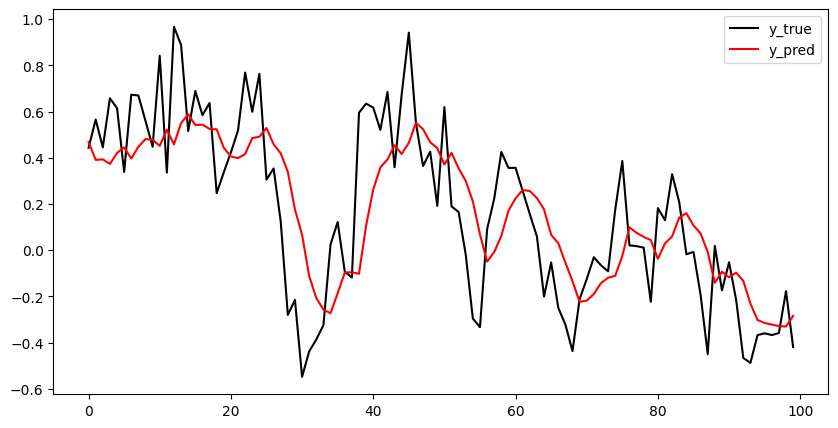

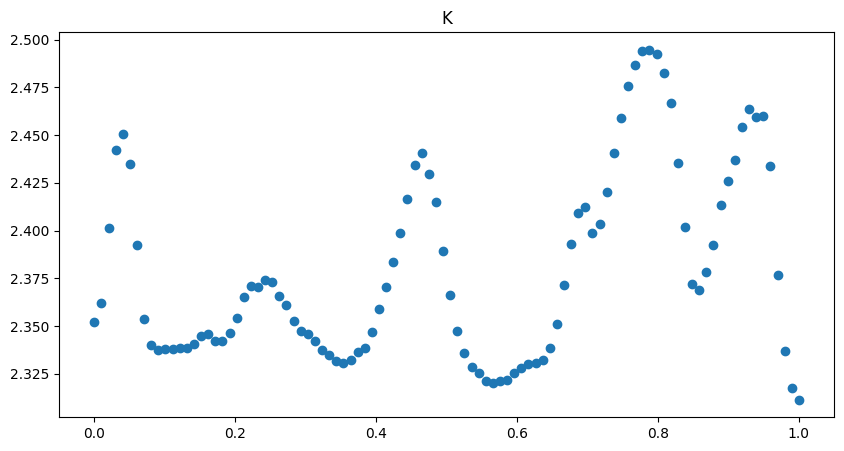

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_true,color='k',label='y_true')
plt.plot(y_pred,color='r',label='y_pred')
plt.legend()

plt.figure(figsize=(10,5))
plt.scatter(torch.linspace(0,1,100),sum(K_hist,2))
plt.title('K')